In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt 
import time
import random
import os
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree # for tree.plot_tree()
from sklearn.tree import export_text # for export_text()
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

In [2]:
# Manually download dataset
heart = pd.read_csv("heart_disease_health_indicators.csv")
    
# Even from just a cursory info() summary, we can see that the dataset is already pre-cleaned for us for the most part.
print(heart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253661 entries, 0 to 253660
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HeartDiseaseorAttack  253661 non-null  int64
 1   HighBP                253661 non-null  int64
 2   HighChol              253661 non-null  int64
 3   CholCheck             253661 non-null  int64
 4   BMI                   253661 non-null  int64
 5   Smoker                253661 non-null  int64
 6   Stroke                253661 non-null  int64
 7   Diabetes              253661 non-null  int64
 8   PhysActivity          253661 non-null  int64
 9   Fruits                253661 non-null  int64
 10  Veggies               253661 non-null  int64
 11  HvyAlcoholConsump     253661 non-null  int64
 12  AnyHealthcare         253661 non-null  int64
 13  NoDocbcCost           253661 non-null  int64
 14  GenHlth               253661 non-null  int64
 15  MentHlth              253661 non-n

In [3]:
print(heart.describe())

       HeartDiseaseorAttack         HighBP       HighChol      CholCheck  \
count         253661.000000  253661.000000  253661.000000  253661.000000   
mean               0.094173       0.428990       0.424113       0.962667   
std                0.292070       0.494933       0.494209       0.189578   
min                0.000000       0.000000       0.000000       0.000000   
25%                0.000000       0.000000       0.000000       1.000000   
50%                0.000000       0.000000       0.000000       1.000000   
75%                0.000000       1.000000       1.000000       1.000000   
max                1.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke       Diabetes  \
count  253661.000000  253661.000000  253661.000000  253661.000000   
mean       28.382475       0.443186       0.040570       0.296904   
std         6.608638       0.496763       0.197292       0.698147   
min        12.000000       0.000000    

In [4]:
print(heart['HeartDiseaseorAttack'].value_counts())

0    229773
1     23888
Name: HeartDiseaseorAttack, dtype: int64


In [5]:
for col in heart.columns:
    print(heart[col].value_counts())
    print("______________________________")

0    229773
1     23888
Name: HeartDiseaseorAttack, dtype: int64
______________________________
0    144843
1    108818
Name: HighBP, dtype: int64
______________________________
0    146080
1    107581
Name: HighChol, dtype: int64
______________________________
1    244191
0      9470
Name: CholCheck, dtype: int64
______________________________
27    24604
26    20562
24    19550
25    17144
28    16543
      ...  
85        1
91        1
86        1
90        1
78        1
Name: BMI, Length: 84, dtype: int64
______________________________
0    141242
1    112419
Name: Smoker, dtype: int64
______________________________
0    243370
1     10291
Name: Stroke, dtype: int64
______________________________
0    213690
2     35342
1      4629
Name: Diabetes, dtype: int64
______________________________
1    191914
0     61747
Name: PhysActivity, dtype: int64
______________________________
1    160888
0     92773
Name: Fruits, dtype: int64
______________________________
1    205830
0     47831


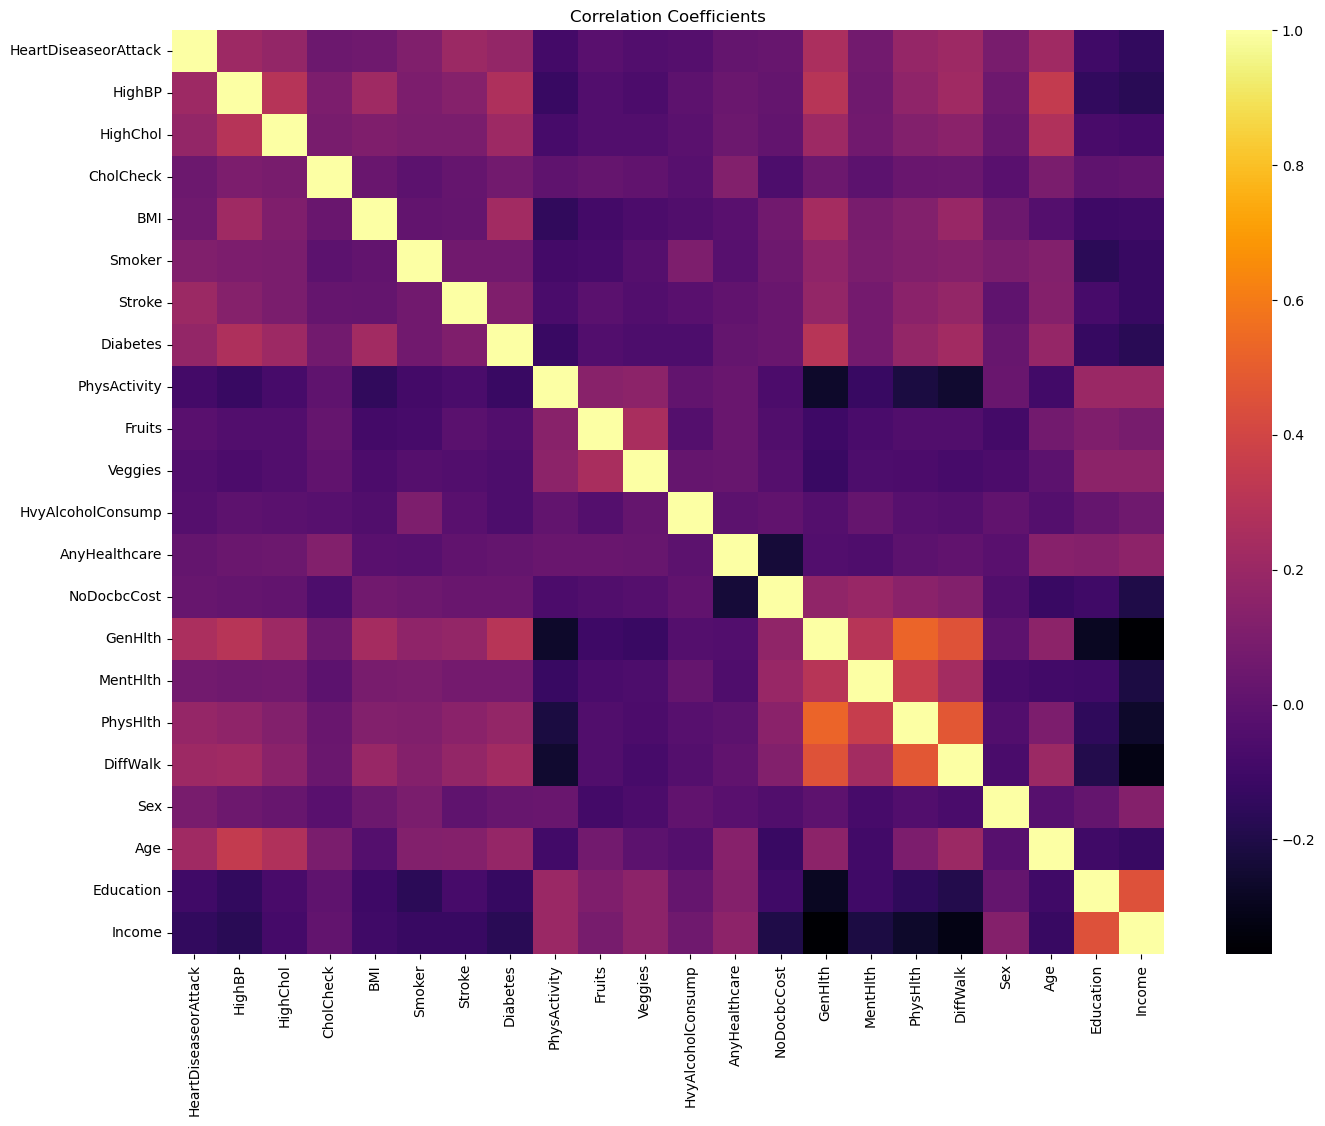

In [6]:
plt.figure(figsize=(16,12))
sns.heatmap(heart.corr(), annot=False, cmap='inferno')
plt.title('Correlation Coefficients')
plt.show()

In [7]:
# Set X, y
X = heart.loc[:,heart.columns != 'HeartDiseaseorAttack']
y = heart[['HeartDiseaseorAttack']]

# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=451, stratify=y)

# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5, random_state=451, stratify=y_tmp)

In [8]:
# Oversample the minority class in the training data (i.e. HeartDiseaseorAttack == 1)
rs = RandomOverSampler(random_state=451, sampling_strategy = 1/3)
X_train_resampled, y_train_resampled = rs.fit_resample(X_train, y_train)

In [9]:
# Compare original ratio vs. oversample ratio
print(f'Our original ratio of heart attack/disease incidence was:')
print(round(heart['HeartDiseaseorAttack'].value_counts()[1] / (len(heart['HeartDiseaseorAttack'])),3))

print('\nOur new ratio, after oversampling, is ')
print(y_train_resampled['HeartDiseaseorAttack'].value_counts()[1] / (len(y_train_resampled['HeartDiseaseorAttack'])))

Our original ratio of heart attack/disease incidence was:
0.094

Our new ratio, after oversampling, is 
0.2499979599330858


In [10]:
# Perform a logistic regression on the entire dataset to predict HeartDiseaseorAttack
#clf = LogisticRegression(max_iter = 3000)
#clf.fit(X_train, y_train.values.ravel())
#score_orig = clf.score(X_test, y_test.values.ravel())

In [11]:
# Fit a logistic regression 

# Find best parametrization
parameters = [{'C': np.arange(10, 400, 10)}]

start_time = datetime.now().strftime("%H:%M:%S")
print("Start Time =", start_time)

base_model = linear_model.LogisticRegression(max_iter = 3000)
clf = GridSearchCV(base_model, parameters, n_jobs = 5)
clf.fit(X_train_resampled, y_train_resampled.values.ravel())
#score_oversample = clf.score(X_valid, y_valid.values.ravel())

end_time = datetime.now().strftime("%H:%M:%S")
print("End Time =", end_time)

#print(f'The logistic regression scores {score_orig} before oversampling, and scores {score_oversample} after oversampling.')

print(f'Best hyperparameter: {clf.best_params_}')
print(f'Accuracy on validation data: {clf.score(X_valid,y_valid)}')

Start Time = 11:27:59
End Time = 11:38:17
Best hyperparameter: {'C': 110}
Accuracy on validation data: 0.8753843727824647


In [14]:
logistic_reg = linear_model.LogisticRegression(max_iter = 3000, C = 110)
logistic_reg.fit(X_train, y_train.values.ravel())

logistic_reg_auc = roc_auc_score(y_true=y_test.values.ravel(), y_score=logistic_reg.predict_proba(X_test)[:, 1])
logistic_reg_accuracy = accuracy_score(y_true = y_test.values.ravel(), y_pred = logistic_reg.predict(X_test))
logistic_reg_precision = precision_score(y_true = y_test.values.ravel(), y_pred = logistic_reg.predict(X_test))
logistic_reg_recall = recall_score(y_true = y_test.values.ravel(), y_pred = logistic_reg.predict(X_test))

print(f'AUC: {logistic_reg_auc:.3}')
print(f'Accuracy: {logistic_reg_accuracy:.3}')
print(f'Precision: {logistic_reg_precision:.3}')
print(f'Recall: {logistic_reg_recall:.3}')

AUC: 0.861
Accuracy: 0.909
Precision: 0.564
Recall: 0.136


In [16]:
# Fit a lasso model to hopefully help with feature selection
start_time = datetime.now().strftime("%H:%M:%S")
print("Start Time =", start_time)

# Perform a lasso regression to perform feature selection
#lasso_model = linear_model.LassoCV(max_iter=2000, random_state=451)
#lasso_model.fit(X_train, y_train.values.ravel())
#lasso_orig = lasso_model.score(X_test, y_test.values.ravel())

lasso_model = linear_model.LassoCV(max_iter=2000, random_state=451, n_jobs=-1)
lasso_model.fit(X_train_resampled, y_train_resampled.values.ravel())
lasso_oversample = lasso_model.score(X_test, y_test.values.ravel())
              
end_time = datetime.now().strftime("%H:%M:%S")
print("End Time =", end_time)

# print(f'The lasso regression scores {lasso_orig} before oversampling, and scores {lasso_oversample} after oversampling.')

# Read out attributes
#coeffs = lasso_model2.coef_         # dense np.array
#coeffs = lasso_model2.sparse_coef_  # sparse matrix

#coeffs = lasso_model2.intercept_    # probably also relevant

# print(f'The lasso model coefficients are: \n{lasso_model2.coef_}')

print("\nThe LASSO model set the following columns to 0:")
print(np.array(X.columns)[lasso_model.coef_==0])

print("\nAnd the following columns have nonzero coefficients:")
print(np.array(X.columns)[lasso_model.coef_!=0])

Start Time = 11:45:15
End Time = 11:45:16
The LASSO model set the following columns to 0:
['PhysActivity' 'AnyHealthcare']

And the following columns have nonzero coefficients:
['HighBP' 'HighChol' 'CholCheck' 'BMI' 'Smoker' 'Stroke' 'Diabetes'
 'Fruits' 'Veggies' 'HvyAlcoholConsump' 'NoDocbcCost' 'GenHlth' 'MentHlth'
 'PhysHlth' 'DiffWalk' 'Sex' 'Age' 'Education' 'Income']


In [ ]:
#test a logistic regression limited to the above variables:
X_train_new = X_train_resampled[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 
                                 'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
                                 'Sex', 'Age', 'Income']]
X_test_new = X_test[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 
                                 'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
                                 'Sex', 'Age', 'Income']]

clf3 = LogisticRegression(max_iter = 3000)
clf3.fit(X_train_new, y_train_resampled.values.ravel())
score_oversample = clf3.score(X_test_new, y_test.values.ravel())
print(score_oversample)


print('\n\nThe confusion matrix is as follows:')
# Confusion matrix. 'metrics' display usage from https://www.w3schools.com/python/python_ml_confusion_matrix.asp
clf_predict = clf3.predict(X_test_new)
conf_matrix = confusion_matrix(y_test, clf_predict)
conf_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
conf_matrix_display.plot()
plt.show()

